In [173]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [151]:
df_desc = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name='descriptions')
df_hedge_fund = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name='hedge_fund_series').rename(columns={'Unnamed: 0':'Date'}).set_index('Date')
df_merrill_factors = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name='merrill_factors').rename(columns={'Unnamed: 0':'Date'}).set_index('Date')
df_other = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name='other_data')

In [152]:
# 2
def calculate_return_statistics(df, annualization_factor=1):
    summary_df = pd.DataFrame(index = df.columns)
    summary_df['Mean'] = df.mean() * annualization_factor
    summary_df['Volatility'] = df.std() * (annualization_factor ** 0.5)
    summary_df['Sharpe_ratio'] = summary_df['Mean'] / summary_df['Volatility'] 
    return summary_df
    
# 2.1
summary_statistics = calculate_return_statistics(df_hedge_fund)
print(tabulate(summary_statistics, headers=summary_statistics.columns, tablefmt="heavy_grid"))

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃                ┃       Mean ┃   Volatility ┃   Sharpe_ratio ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃ HFRIFWI Index  ┃ 0.00402458 ┃    0.0171693 ┃       0.234405 ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃ MLEIFCTR Index ┃ 0.00302383 ┃    0.0162049 ┃       0.186599 ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃ MLEIFCTX Index ┃ 0.00288376 ┃    0.01616   ┃       0.178451 ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃ HDG US Equity  ┃ 0.00206766 ┃    0.0168609 ┃       0.122631 ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃ QAI US Equity  ┃ 0.00213777 ┃    0.0144364 ┃       0.148082 ┃
┗━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━┛


In [153]:
# 2.2
def calculate_max_drawdown(df):
    drawdown_df = pd.DataFrame(index=df.columns)
    cumulative_returns = (1+df).cumprod()
    rolling_max = cumulative_returns.cummax()
    curr_drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = curr_drawdown.min()
    date_max_drawdown = curr_drawdown.idxmin()
    drawdown_df['Max Drawdown'] = max_drawdown
    drawdown_df['Bottom'] = date_max_drawdown

    for col in df.columns:
        drawdown_df.loc[col, 'Peak'] = pd.to_datetime((rolling_max.loc[:date_max_drawdown[col], col]).idxmax())
        recovery_df = (curr_drawdown.loc[date_max_drawdown[col]:, col])
        try:
            drawdown_df.loc[col, 'Recovery'] = pd.to_datetime(recovery_df[recovery_df >=0].index[0])
        except:
            drawdown_df.loc[col, 'Recovery'] = pd.to_datetime(None)
    try:
        drawdown_df['Time To Recover'] = (drawdown_df['Recovery'] - drawdown_df['Peak'])
    except:
        drawdown_df['Time To Recover'] = None
    return drawdown_df
    
def calculate_taik_risk_statistics(df, quantile=0.05):
    summary_df = pd.DataFrame(index=df.columns)
    summary_df['Skewness'] = df.skew()
    summary_df['Excess Kurtosis'] = df.kurt()-3
    summary_df[f'VaR({quantile})'] = df.quantile(0.05, axis=0)
    summary_df[f'CVaR({quantile})'] = df[df.le(df.quantile(0.05, axis=0))].mean()
    summary_df['Max'] = df.max()
    summary_df['Min'] = df.min()
    summary_df = summary_df.join(calculate_max_drawdown(df))
    return summary_df

tail_risk_statistics = calculate_taik_risk_statistics(df_hedge_fund)
print(tabulate(tail_risk_statistics, headers=tail_risk_statistics.columns, tablefmt="heavy_grid"))

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                ┃   Skewness ┃   Excess Kurtosis ┃   VaR(0.05) ┃   CVaR(0.05) ┃       Max ┃        Min ┃   Max Drawdown ┃ Bottom              ┃ Peak                ┃ Recovery            ┃ Time To Recover    ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━┫
┃ HFRIFWI Index  ┃  -0.963318 ┃           2.76307 ┃  -0.0242931 ┃   -0.037478  ┃ 0.058602  ┃ -0.0907837 ┃      -0.115473 ┃ 2020-03-31 00:00:00 ┃ 2019-12-31 00:00:00 ┃ 2020-08-31 00:00:00 ┃ 244 days 00:00:00  ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━

In [216]:
# 3
def get_regression_statistics(X, Y, annualization = 1, error_variance=False):
    if not isinstance(X, pd.DataFrame):
        X = X.to_frame()
    if not isinstance(Y, pd.DataFrame):
        Y = Y.to_frame()
    df = Y.join(X, how='inner')
    Y = df[Y.columns]
    X = df[X.columns]

    regression_df = pd.DataFrame(index = Y.columns)
    for col in Y.columns:
        y = Y[col]
        data = X.join(y, lsuffix='X')
        mask = data.notnull().all(axis=1)
        y = y[mask]
        x = X[mask]    
    
        model = LinearRegression().fit(X, y)
        regression_df.loc[col, 'Alpha'] = model.intercept_ * annualization
        regression_df.loc[col, X.columns + " (Beta)"] = model.coef_
        regression_df.loc[col, 'R-squared'] = model.score(X, y)

        y_fit = model.predict(X)
        residuals = y - y_fit

        if error_variance:
            print(f"Variance of Residuals: {np.var(residuals, ddof=1)}")
        

        # Treynor Ratio
        if X.shape[1] == 1:
            try:
                regression_df.loc[col, 'Treynor Ratio'] = (y.mean()/model.coef_)*annualization
            except:
                regression_df.loc[col, 'Treynor Ratio'] = None
        
        # Information Ratio
        try:
            regression_df.loc[col, 'Information Ratio'] = (model.intercept_ / residuals.std()) * (annualization)**0.5
        except:
            regression_df.loc[col, 'Information Ratio'] = None
            
    return regression_df

regression_results = get_regression_statistics(df_merrill_factors['SPY US Equity'],df_hedge_fund,annualization=12)
print(tabulate(regression_results, headers=regression_results.columns, tablefmt="heavy_grid"))

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃                ┃       Alpha ┃   SPY US Equity (Beta) ┃   R-squared ┃   Treynor Ratio ┃   Information Ratio ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━┫
┃ HFRIFWI Index  ┃ -0.00114486 ┃               0.346131 ┃    0.71148  ┃       0.139528  ┃          -0.0358361 ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━┫
┃ MLEIFCTR Index ┃ -0.0127614  ┃               0.343383 ┃    0.786051 ┃       0.105672  ┃          -0.491479  ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━┫
┃ MLEIFCTX Index ┃ -0.0142691  ┃               0.342171 ┃    0.784862 ┃       0.101134  ┃          -0.549547  ┃
┣━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━

# 2.4
2.4.1 Based on the negative IR, we can say that the SPY has performed better than any of these hedge funds. 

2.4.2 QAI has performed better than HDG (As seen by Information Ratio, Treynor Ratio and Sharpe Ratio)
2.4.3

Max Correlation pair is ('MLEIFCTR Index', 'MLEIFCTX Index')
Min Correlation pair is ('QAI US Equity', 'HFRIFWI Index')


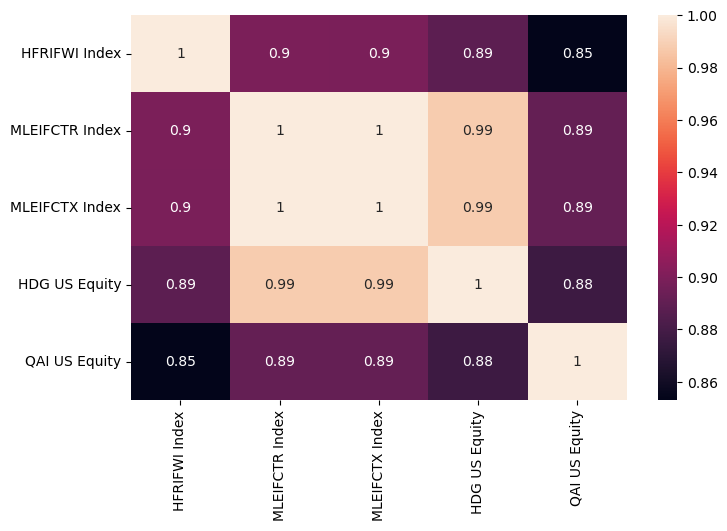

In [203]:
# 2.5
def plot_correlation_matrix(df, max_min=True):
    fig, ax = plt.subplots(figsize=(8,5))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns, annot=True)
    
    corrs = correlation_matrix.unstack().sort_values().to_frame('Corr')
    corrs = corrs[corrs['Corr']!=1]
    corrs_max = corrs.index[-1]
    corrs_min = corrs.index[0]
    
    print(f'Max Correlation pair is {corrs_max}')
    print(f'Min Correlation pair is {corrs_min}')
plot_correlation_matrix(df_hedge_fund)

In [206]:
# 2.6
regression_results = get_regression_statistics(X,y,annualization=12, error_variance=True).T
print(tabulate(regression_results, headers=regression_results.columns, tablefmt="heavy_grid"))

Variance of Residuals: 4.726106116725482e-05
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃                      ┃   HFRIFWI Index ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ Alpha                ┃       0.014824  ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ const (Beta)         ┃       0         ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ SPY US Equity (Beta) ┃       0.0364833 ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ USGG3M Index (Beta)  ┃       0.146336  ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ EEM US Equity (Beta) ┃       0.0816112 ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ EFA US Equity (Beta) ┃       0.084638  ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ EUO US Equity (Beta) ┃       0.0288057 ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ IWM US Equity (Beta) ┃       0.145111  ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ R-squared            ┃       0.839676  ┃
┣━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ Information Ratio    ┃       0.622478  ┃
┗━━━━━━━━

In [207]:
#2.7
model = RollingOLS(y,X,window=60)
rolling_betas = model.fit().params.copy()
rolling_betas.tail()

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Date,,,,,,,
2024-05-31,0.003754,-0.005914,-0.205822,0.104899,0.018399,0.027153,0.228200
2024-06-30,0.003864,-0.011391,-0.253834,0.101264,0.024686,0.025227,0.230355
2024-07-31,0.003823,0.009341,-0.442590,0.110699,0.027648,0.034371,0.207162
2024-08-31,0.003744,0.009885,-0.407423,0.110837,0.027656,0.032872,0.206847
2024-09-30,0.004033,0.003148,-0.438009,0.113829,0.043127,0.043991,0.202864


In [208]:
Rolling_IS_prediction = (rolling_betas * X).sum(axis=1,skipna=False)
Rolling_OOS_prediction = (rolling_betas.shift() * X).sum(axis=1,skipna=False)

replication = df_hedge_fund[['HFRIFWI Index']].copy()
replication['Static-IS-Prediction'] = static_model.fittedvalues

replication['Rolling-IS-Prediction'] = Rolling_IS_prediction
replication['Rolling-OOS-Prediction'] = Rolling_OOS_prediction
replication.tail()

,HFRIFWI Index,Static-IS-Prediction,Rolling-IS-Prediction,Rolling-OOS-Prediction
Date,,,,
2024-05-31,0.0141,0.016109,0.016235,0.016488
2024-06-30,-0.0003,0.003059,0.002749,0.003343
2024-07-31,0.0127,0.019724,0.024480,0.027494
2024-08-31,0.0025,0.002795,-0.000435,-0.000579
2024-09-30,0.0123,0.008683,0.010330,0.010137


In [209]:
# Performance of Rolling Replication:
rolling_oos_pred_df = replication.dropna(subset=['HFRIFWI Index', 'Rolling-OOS-Prediction'])
y_actual = rolling_oos_pred_df['HFRIFWI Index']
y_pred_oos = rolling_oos_pred_df['Rolling-OOS-Prediction']

mse_oos = mean_squared_error(y_actual, y_pred_oos)
rmse_oos = np.sqrt(mse_oos)
mae_oos = mean_absolute_error(y_actual, y_pred_oos)
r2_oos = r2_score(y_actual, y_pred_oos)
correlation_oos = np.corrcoef(y_actual, y_pred_oos)[0, 1]

print(f"Out-of-Sample Performance:")
print(f"Actual Mean: {y_actual.mean()} Fitted Mean: {y_pred_oos.mean()}")
print(f"MSE: {mse_oos}")
print(f"RMSE: {rmse_oos}")
print(f"MAE: {mae_oos}")
print(f"R-squared: {r2_oos}")
print(f"Correlation: {correlation_oos}")

Out-of-Sample Performance:
Actual Mean: 0.005060442705528549 Fitted Mean: 0.0037544408012920175
MSE: 6.960179196296274e-05
RMSE: 0.008342768842714194
MAE: 0.005937011032677748
R-squared: 0.7994295353835923
Correlation: 0.8975789048014755


In [210]:
X_no_int = df_merrill_factors
static_model_noint = sm.OLS(y,X_no_int).fit()
betas = pd.DataFrame(static_model.params,columns=['With Intercept']).T
betas.loc['Without Intercept'] = static_model_noint.params
print(tabulate(betas, headers=betas.columns, tablefmt="heavy_grid"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃                   ┃        const ┃   SPY US Equity ┃   USGG3M Index ┃   EEM US Equity ┃   EFA US Equity ┃   EUO US Equity ┃   IWM US Equity ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ With Intercept    ┃   0.00123534 ┃       0.0364833 ┃       0.146336 ┃       0.0816112 ┃       0.084638  ┃       0.0288057 ┃        0.145111 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━┫
┃ Without Intercept ┃ nan          ┃       0.0506672 ┃       0.499336 ┃       0.0808655 ┃       0.0791457 ┃       0.0313732 ┃        0.142651 ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━

In [211]:
model = RollingOLS(y,X_no_int,window=60,)
rolling_betas = model.fit().params.copy()
Rolling_IS_prediction_no_intercept = (rolling_betas * Xnoint).sum(axis=1,skipna=False)
Rolling_OOS_prediction_no_intercept = (rolling_betas.shift() * Xnoint).sum(axis=1,skipna=False)
rolling_betas.tail()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Date,,,,,,
2024-05-31,0.024582,0.751372,0.109796,0.000602,0.036313,0.221889
2024-06-30,0.014905,0.707672,0.102983,0.011491,0.033980,0.225585
2024-07-31,0.034318,0.510025,0.112094,0.014953,0.042024,0.202922
2024-08-31,0.034005,0.517201,0.112858,0.014170,0.040149,0.203582
2024-09-30,0.030052,0.551628,0.115575,0.025910,0.049764,0.200071


In [212]:
replication['Static-IS-Prediction-No_Intercept'] = static_model_noint.fittedvalues
replication['Rolling-IS-Prediction-No_Intercept'] = rep_IS_noint
replication['Rolling-OOS-Prediction-No_Intercept'] = rep_OOS_noint
replication.tail()

,HFRIFWI Index,Static-IS-Prediction,Rolling-IS-Prediction,Rolling-OOS-Prediction,Static-IS-Prediction-No_Intercept,Rolling-IS-Prediction-No_Intercept,Rolling-OOS-Prediction-No_Intercept
Date,,,,,,,
2024-05-31,0.0141,0.016109,0.016235,0.016488,0.016691,0.016948,0.017349
2024-06-30,-0.0003,0.003059,0.002749,0.003343,0.004090,0.004724,0.005754
2024-07-31,0.0127,0.019724,0.024480,0.027494,0.019770,0.024272,0.027216
2024-08-31,0.0025,0.002795,-0.000435,-0.000579,0.003159,-0.000300,-0.000361
2024-09-30,0.0123,0.008683,0.010330,0.010137,0.008977,0.010563,0.010378


In [213]:
rolling_oos_pred_noint_df = replication.dropna(subset=['HFRIFWI Index', 'Rolling-OOS-Prediction-No_Intercept'])
y_actual = rolling_oos_pred_noint_df['HFRIFWI Index']
y_pred_oos = rolling_oos_pred_noint_df['Rolling-OOS-Prediction-No_Intercept']

mse_oos = mean_squared_error(y_actual, y_pred_oos)
rmse_oos = np.sqrt(mse_oos)
mae_oos = mean_absolute_error(y_actual, y_pred_oos)
r2_oos = r2_score(y_actual, y_pred_oos)
correlation_oos = np.corrcoef(y_actual, y_pred_oos)[0, 1]

print(f"Out-of-Sample Performance (No Intercept):")
print(f"Actual Mean: {y_actual.mean()} Fitted Mean: {y_pred_oos.mean()}")
print(f"MSE: {mse_oos}")
print(f"RMSE: {rmse_oos}")
print(f"MAE: {mae_oos}")
print(f"R-squared: {r2_oos}")
print(f"Correlation: {correlation_oos}")

Out-of-Sample Performance (No Intercept):
Actual Mean: 0.005060442705528549 Fitted Mean: 0.004151183965743737
MSE: 7.201581141952294e-05
RMSE: 0.008486213019923725
MAE: 0.005880223818790839
R-squared: 0.7924730908677244
Correlation: 0.8933934823818829
